## Attention-Model

This network spreading model considers the role of attention span in modeling the spread of memes on social networks. Agents maintain a limited attention span (queue) of their most recently observed memes. They draw from this queue to re-share memes.

In [2]:
from queue import Queue 
import networkx as nx
import collections
import random
import matplotlib.pyplot as plt

In [3]:
class Agent:
    
    def __init__(self,ID,attention_span,interests):
        self.ID = ID
        self.attention_span = attention_span
        self.dq = collections.deque(maxlen=attention_span)
        self.interests = interests
        self.meme_share_chance = abs(random.random() - random.random()) #weighted towards 0
        self.meme_create_chance = abs(random.random() - random.random()) #weighted towards 0
        
    def add_meme(self,meme):
        self.dq.append(meme)
        
    def select_meme(self):
        if(len(self.dq) == 0):
            return None
        else:
            return random.choice(list(self.dq)) #Randomly select meme from queue
        #return item from queue at random, weighted by quality and similarity to agent interests
                
#Consider adding some variable(s) to capture agent interests/topics. 
#This could influence which meme in queue they select to share.

#When agents share memes, that meme gets added to the queue of their neighbors.
#The shared meme also remains in the queue of the agent who shared it. (thoughts on this?)

In [4]:
class Meme:
    
    def __init__(self,ID,quality,topic):
        self.ID = ID
        self.quality = quality
        self.topic = topic
    
#Memes could have some quality/novelty attribute and some topic attribute pulled from some distributions.
#These would be considered by the agent when selected which meme to share.

## Initialize Network

In [5]:
g = nx.DiGraph()

In [6]:
import gzip
import csv

following = {}

with gzip.open('twitter_combined.txt.gz', "rt", encoding="utf-8") as input_file:
    reader = csv.reader(input_file, delimiter=' ', quotechar='"')
    for record in reader:
        if(int(record[0]) not in following.keys()):
            following[int(record[0])] = [int(record[1])]
        else:
            following[int(record[0])].append(int(record[1]))

In [7]:
for node in following.keys():
    g.add_node(node)
for node in following.keys():
    for target in following[node]:
        g.add_edge(target,node) #Edge Direction from followee to follower - edges point outward toward followers

## Initialize Agents

In [8]:
agents = {}
for node in g.nodes():
    agent = Agent(node, random.randint(5,10), [])
    agents[node] = agent

## Initiate Meme Spread

In [9]:
meme_id_counter = 0

In [10]:
def initiate_meme_spread(agents):
    global meme_id_counter
    for agent in agents.keys():
        if random.random() < agents[agent].meme_create_chance:
            new_meme = Meme(meme_id_counter, random.randint(0,10), random.randint(0,20))
            agents[agent].add_meme(new_meme)
            meme_id_counter = meme_id_counter + 1
    return agents

## Iterate Meme Spread

In [11]:
def iterate_meme_spread(g, agents):
    global meme_id_counter
    for node in g.nodes():
        if random.random() < agents[node].meme_create_chance:
            new_meme = Meme(meme_id_counter, random.randint(0,10), random.randint(0,20))
            agents[node].add_meme(new_meme)
            meme_id_counter = meme_id_counter + 1
        if random.random() < agents[node].meme_share_chance:
            meme = agents[node].select_meme()
            if not meme == None:
                for neighbor in g.neighbors(node):
                    agents[neighbor].add_meme(meme)
    return agents

## Analyze Meme Spread

In [12]:
def analyze_meme_spread(agents):
    memes = {}
    for agent in agents.keys():
        for meme in agents[agent].dq:
            if not meme.ID in memes.keys():
                memes[meme.ID] = 1
            else:
                memes[meme.ID] = memes[meme.ID] + 1
    sorted_memes = {k: v for k, v in sorted(memes.items(), key=lambda item: item[1], reverse=True)}
    return sorted_memes

## Simulate Meme Spread

In [19]:
def simulate_meme_spread(g, agents, iterations):
    agents = initiate_meme_spread(agents)
    meme_analysis_series = []
    for x in range(0, iterations):
        agents = iterate_meme_spread(g, agents)
        meme_analysis = analyze_meme_spread(agents)
        print({k: meme_analysis[k] for k in list(meme_analysis)[:5]})
        meme_analysis_series.append(meme_analysis)
    return agents, meme_analysis_series

In [20]:
spread,time_series = simulate_meme_spread(g, agents, 10)

{213804: 8388, 731067: 8133, 619120: 7354, 211491: 6231, 781455: 4272}
{706310: 8096, 731067: 6385, 916199: 6157, 619120: 5320, 213804: 5215}
{515862: 17376, 916199: 9470, 619120: 6831, 926461: 6636, 158663: 5094}
{515862: 16995, 862645: 10327, 926461: 9627, 267275: 8940, 158663: 7019}
{926461: 11938, 515862: 11046, 267275: 10636, 1029010: 9919, 781455: 7540}
{267275: 12231, 515862: 12156, 1029010: 9886, 926461: 6595, 889741: 6262}
{926461: 12277, 889741: 12182, 1029010: 8562, 267275: 7655, 515862: 7555}
{926461: 12044, 889741: 10518, 808629: 10190, 267275: 10077, 900381: 6077}
{926461: 11174, 889741: 10095, 267275: 8958, 895835: 8160, 1002214: 7892}
{926461: 11085, 889741: 6907, 839723: 6702, 1002214: 5935, 895835: 5075}


## Visualize Meme Spread

In [83]:
def plot_meme_spread(iterations, time_series, top_range):
    top_memes = {}
    X = range(iterations)
    
    #Populate top memes
    for i in range(iterations):
        labels = (list(time_series[i].keys())[:top_range])
        for label in labels: 
            if label not in top_memes.keys(): top_memes[label] = []
    
    for i in range(iterations):
        for meme in top_memes.keys(): 
            if(meme not in time_series[i].keys()): 
                top_memes[meme].append(0)
            else: 
                top_memes[meme].append(time_series[i][meme])
        
    #Graph memes over time
    for meme in top_memes: 
        plt.title('Top Memes over Time')
        plt.xlabel('Iterations')
        plt.ylabel('Intances of Meme')
        plt.plot(X,top_memes[meme],label=meme)


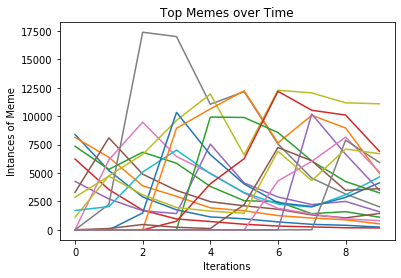

In [84]:
plot_meme_spread(10,time_series,5)